<a href="https://colab.research.google.com/github/CreamCheese-Brotchen/Trending-topic/blob/main/extreme_loss01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [35]:
!pip install darts

  Using cached matplotlib-3.5.1-cp37-cp37m-manylinux_2_5_x86_64.manylinux1_x86_64.whl (11.2 MB)
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.1.3
    Uninstalling matplotlib-3.1.3:
      Successfully uninstalled matplotlib-3.1.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [36]:
!python -m pip uninstall matplotlib
!pip install matplotlib==3.1.3

Found existing installation: matplotlib 3.5.1
Uninstalling matplotlib-3.5.1:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1-py3.7-nspkg.pth
    /usr/local/lib/python3.7/dist-packages/matplotlib-3.5.1.dist-info/*
    /usr/local/lib/python3.7/dist-packages/matplotlib/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axes_grid1/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/axisartist/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/mplot3d/*
    /usr/local/lib/python3.7/dist-packages/mpl_toolkits/tests/*
    /usr/local/lib/python3.7/dist-packages/pylab.py
Proceed (y/n)? y
  Successfully uninstalled matplotlib-3.5.1
  Using cached matplotlib-3.1.3-cp37-cp37m-manylinux1_x86_64.whl (13.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbpr

In [37]:
import matplotlib.pyplot as plt
import pandas as pd
from darts import TimeSeries
from darts.utils.timeseries_generation import gaussian_timeseries, linear_timeseries, sine_timeseries
from darts.models import RNNModel, TCNModel, TransformerModel, NBEATSModel, BlockRNNModel
from darts.metrics import mape, smape

from sklearn.metrics import mean_absolute_percentage_error
series_ai = pd.read_csv('ai_count_no_ouliers.csv')

In [38]:
from darts.dataprocessing.transformers import Scaler
from darts import TimeSeries
scaler_ai_retweet = Scaler()

series_ai_count = scaler_ai_retweet.fit_transform(
        TimeSeries.from_dataframe(
            series_ai, 'date', ['count'])
    ) 
# series_ai_count.plot(label ='count')
# plt.xlabel('date')
# plt.ylabel('tweet_count')
# fig1 = plt.gcf()
# plt.legend();
# plt.show()
#fig1.savefig('tweet_count.png')

In [39]:
train_tweet_count, val_tweet_count = series_ai_count.split_after(pd.Timestamp('20200930'))

import torch

## model 

In [53]:
def try_loss(pred, true):
  #print(pred, true)
  inter = (pred - true).fill_(0)

  positive = true.mean()+torch.std(true)
  negative = true.mean()-torch.std(true)

  for i in range(0,len(inter)):
    for j in range(0,len(inter[i])):
      if((pred[i][j]<= positive and pred[i][j]>= negative) and (true[i][j]> positive or true[i][j]<negative)):
        inter[i][j]=torch.abs((pred[i][j]-true[i][j]))*2

  intersection = torch.abs(pred - true)**2

  v = (intersection + inter).mean()
  return v

In [14]:
lam = 2
def custom_loss(pred, true):
  #print(pred, true)
  inter = (pred - true).fill_(0)

  positive = true.mean()+torch.std(true)
  negative = true.mean()-torch.std(true)

  for i in range(0,len(inter)):
    for j in range(0,len(inter[i])):
      if((pred[i][j]<= positive and pred[i][j]>= negative) and (true[i][j]> positive or true[i][j]<negative)):
        inter[i][j] = torch.abs((pred[i][j]-true[i][j]))

  intersection = torch.abs(pred - true)**2

  v = (intersection+ lam*inter).mean()
  return v

In [54]:
model_ai = NBEATSModel(input_chunk_length=60, output_chunk_length=7, n_epochs=100, random_state=0,
                                          loss_fn = try_loss)
train = model_ai.fit([train_tweet_count], val_series = [val_tweet_count], verbose=True)

pred_ai = model_ai.predict(n=75, series = train_tweet_count) 
error_tweet = mape(val_tweet_count[:75],pred_ai)
print('\n')
print("this is the error for the tweet_count:",error_tweet)

[2021-12-15 12:52:25,734] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 12:52:25,734] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 12:52:25,832] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 12:52:25,832] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:01<02:25,  1.47s/it]

 11%|█         | 11/100 [00:15<02:03,  1.39s/it]

 21%|██        | 21/100 [00:29<01:50,  1.40s/it]

 31%|███       | 31/100 [00:43<01:36,  1.40s/it]

 41%|████      | 41/100 [00:57<01:22,  1.40s/it]

 51%|█████     | 51/100 [01:11<01:09,  1.41s/it]

 61%|██████    | 61/100 [01:25<00:54,  1.41s/it]

 71%|███████   | 71/100 [01:39<00:40,  1.40s/it]

 81%|████████  | 81/100 [01:53<00:26,  1.40s/it]

 91%|█████████ | 91/100 [02:07<00:12,  1.39s/it]

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]



this is the error for the tweet_count: 28.81634969204313


# 新段落

In [50]:
train.plot()

AttributeError: ignored

## experiment with different lambda

In [17]:
def experiment(lam_list):
  for parameter in lam_list:
    lam = parameter

    def custom_loss(pred, true):
      inter = (pred - true).fill_(0)

      positive = true.mean()+torch.std(true)
      negative = true.mean()-torch.std(true)

      for i in range(0,len(inter)):
        for j in range(0,len(inter[i])):
          if((pred[i][j]<= positive and pred[i][j]>= negative) and (true[i][j]> positive or true[i][j]<negative)):
            inter[i][j] = torch.abs((pred[i][j]-true[i][j]))

      intersection = torch.abs(pred - true)**2
      v = (intersection+ lam*inter).mean()
      return v

    model_ai = NBEATSModel(input_chunk_length=60, output_chunk_length=7, n_epochs=100, random_state=0,
                                          loss_fn = custom_loss,)
    model_ai.fit([train_tweet_count], val_series = [val_tweet_count], verbose=True)
    pred_ai = model_ai.predict(n=75, series = train_tweet_count) 
    error_tweet = mape(val_tweet_count[:75],pred_ai)
    print('parameter: %f, mape:%.4f'%(lam, error_tweet))

In [18]:
lam_list = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75]
experiment(lam_list)

[2021-12-15 07:46:48,342] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:46:48,342] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:46:48,435] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 07:46:48,435] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
  1%|          | 1/100 [00:01<02:27,  1.49s/it]

 11%|█         | 11/100 [00:15<02:05,  1.41s/it]

 21%|██        | 21/100 [00:29<01:50,  1.40s/it]

 31%|███       | 31/100 [00:43<01:36,  1.39s/it]

 41%|████      | 41/100 [00:57<01:22,  1.39s/it]

 51%|█████     | 51/100 [01:12<01:15,  1.53s/it]

 61%|██████    | 61/100 [01:25<00:54,  1.39s/it]

 71%|███████   | 71/100 [01:39<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:53<00:26,  1.38s/it]

 91%|█████████ | 91/100 [02:07<00:12,  1.39s/it]

100%|██████████| 100/100 [02:19<00:00,  1.40s/it]
[2021-12-15 07:49:08,275] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:49:08,275] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:49:08,358] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 07:49:08,358] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 0.250000, mape:41.9495


  1%|          | 1/100 [00:01<02:21,  1.43s/it]

 11%|█         | 11/100 [00:15<02:05,  1.41s/it]

 21%|██        | 21/100 [00:29<01:50,  1.40s/it]

 31%|███       | 31/100 [00:43<01:35,  1.39s/it]

 41%|████      | 41/100 [00:57<01:21,  1.38s/it]

 51%|█████     | 51/100 [01:10<01:08,  1.39s/it]

 61%|██████    | 61/100 [01:24<00:53,  1.38s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.38s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.38s/it]

 91%|█████████ | 91/100 [02:05<00:12,  1.38s/it]

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]
[2021-12-15 07:51:26,883] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:51:26,883] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:51:26,966] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 07:51:26,966] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 0.500000, mape:39.8065


  1%|          | 1/100 [00:01<02:20,  1.42s/it]

 11%|█         | 11/100 [00:15<02:05,  1.41s/it]

 21%|██        | 21/100 [00:29<01:51,  1.41s/it]

 31%|███       | 31/100 [00:43<01:36,  1.40s/it]

 41%|████      | 41/100 [00:57<01:22,  1.39s/it]

 51%|█████     | 51/100 [01:11<01:08,  1.39s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.39s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.40s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.39s/it]

 91%|█████████ | 91/100 [02:06<00:12,  1.39s/it]

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]
[2021-12-15 07:53:46,083] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:53:46,083] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:53:46,169] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 07:53:46,169] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 0.750000, mape:35.7826


  1%|          | 1/100 [00:01<02:21,  1.43s/it]

 11%|█         | 11/100 [00:15<02:04,  1.39s/it]

 21%|██        | 21/100 [00:29<01:50,  1.39s/it]

 31%|███       | 31/100 [00:42<01:35,  1.39s/it]

 41%|████      | 41/100 [00:56<01:21,  1.39s/it]

 51%|█████     | 51/100 [01:10<01:07,  1.38s/it]

 61%|██████    | 61/100 [01:24<00:53,  1.38s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.38s/it]

 91%|█████████ | 91/100 [02:05<00:12,  1.38s/it]

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]
[2021-12-15 07:56:04,539] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:56:04,539] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:56:04,636] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 07:56:04,636] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 1.000000, mape:41.0536


  1%|          | 1/100 [00:01<02:20,  1.42s/it]

 11%|█         | 11/100 [00:15<02:04,  1.39s/it]

 21%|██        | 21/100 [00:29<01:50,  1.40s/it]

 31%|███       | 31/100 [00:43<01:36,  1.39s/it]

 41%|████      | 41/100 [00:57<01:22,  1.40s/it]

 51%|█████     | 51/100 [01:10<01:08,  1.39s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.39s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.39s/it]

 91%|█████████ | 91/100 [02:06<00:12,  1.39s/it]

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]
[2021-12-15 07:58:23,641] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:58:23,641] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 07:58:23,729] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 07:58:23,729] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 1.250000, mape:43.7386


  1%|          | 1/100 [00:01<02:21,  1.43s/it]

 11%|█         | 11/100 [00:15<02:04,  1.40s/it]

 21%|██        | 21/100 [00:29<01:50,  1.40s/it]

 31%|███       | 31/100 [00:43<01:36,  1.40s/it]

 41%|████      | 41/100 [00:57<01:22,  1.40s/it]

 51%|█████     | 51/100 [01:10<01:08,  1.39s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.40s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.39s/it]

 91%|█████████ | 91/100 [02:06<00:12,  1.39s/it]

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]
[2021-12-15 08:00:42,666] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:00:42,666] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:00:42,750] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 08:00:42,750] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 1.500000, mape:48.0223


  1%|          | 1/100 [00:01<02:21,  1.43s/it]

 11%|█         | 11/100 [00:15<02:03,  1.39s/it]

 21%|██        | 21/100 [00:29<01:49,  1.39s/it]

 31%|███       | 31/100 [00:43<01:36,  1.40s/it]

 41%|████      | 41/100 [00:56<01:22,  1.40s/it]

 51%|█████     | 51/100 [01:10<01:08,  1.40s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.40s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.39s/it]

 91%|█████████ | 91/100 [02:06<00:12,  1.39s/it]

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]
[2021-12-15 08:03:01,671] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:03:01,671] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:03:01,757] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 08:03:01,757] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 1.750000, mape:38.9943


  1%|          | 1/100 [00:01<02:22,  1.44s/it]

 11%|█         | 11/100 [00:15<02:03,  1.39s/it]

 21%|██        | 21/100 [00:29<01:50,  1.39s/it]

 31%|███       | 31/100 [00:43<01:36,  1.39s/it]

 41%|████      | 41/100 [00:56<01:21,  1.39s/it]

 51%|█████     | 51/100 [01:10<01:08,  1.39s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.39s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:52<00:26,  1.39s/it]

 91%|█████████ | 91/100 [02:06<00:12,  1.39s/it]

100%|██████████| 100/100 [02:18<00:00,  1.39s/it]
[2021-12-15 08:05:20,475] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:05:20,475] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:05:20,561] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 08:05:20,561] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 2.000000, mape:28.8163


  1%|          | 1/100 [00:01<02:22,  1.44s/it]

 11%|█         | 11/100 [00:15<02:03,  1.38s/it]

 21%|██        | 21/100 [00:29<01:49,  1.38s/it]

 31%|███       | 31/100 [00:42<01:35,  1.38s/it]

 41%|████      | 41/100 [00:56<01:21,  1.39s/it]

 51%|█████     | 51/100 [01:10<01:07,  1.39s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.39s/it]

 71%|███████   | 71/100 [01:37<00:40,  1.39s/it]

 81%|████████  | 81/100 [01:51<00:26,  1.38s/it]

 91%|█████████ | 91/100 [02:05<00:12,  1.39s/it]

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]
[2021-12-15 08:07:38,669] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:07:38,669] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:07:38,755] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 08:07:38,755] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 2.250000, mape:43.9603


  1%|          | 1/100 [00:01<02:21,  1.43s/it]

 11%|█         | 11/100 [00:15<02:03,  1.39s/it]

 21%|██        | 21/100 [00:29<01:49,  1.38s/it]

 31%|███       | 31/100 [00:42<01:35,  1.39s/it]

 41%|████      | 41/100 [00:56<01:21,  1.39s/it]

 51%|█████     | 51/100 [01:10<01:07,  1.38s/it]

 61%|██████    | 61/100 [01:24<00:53,  1.38s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.38s/it]

 81%|████████  | 81/100 [01:51<00:26,  1.38s/it]

 91%|█████████ | 91/100 [02:05<00:12,  1.39s/it]

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]
[2021-12-15 08:09:56,945] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:09:56,945] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 208 samples.
[2021-12-15 08:09:57,033] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2021-12-15 08:09:57,033] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.


parameter: 2.500000, mape:54.9467


  1%|          | 1/100 [00:01<02:36,  1.58s/it]

 11%|█         | 11/100 [00:15<02:03,  1.39s/it]

 21%|██        | 21/100 [00:29<01:48,  1.38s/it]

 31%|███       | 31/100 [00:42<01:35,  1.39s/it]

 41%|████      | 41/100 [00:56<01:21,  1.39s/it]

 51%|█████     | 51/100 [01:10<01:07,  1.38s/it]

 61%|██████    | 61/100 [01:24<00:54,  1.38s/it]

 71%|███████   | 71/100 [01:38<00:40,  1.38s/it]

 81%|████████  | 81/100 [01:51<00:26,  1.38s/it]

 91%|█████████ | 91/100 [02:05<00:12,  1.38s/it]

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]

parameter: 2.750000, mape:46.3107


MAPE = 28.82%


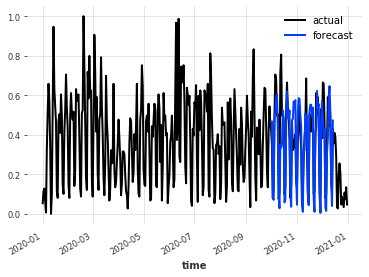

In [24]:
pred_ai = model_ai.predict(n=75, series = train_tweet_count)
error_tweet = mape(val_tweet_count[:75],pred_ai)
print('MAPE = {:.2f}%'.format(mape(val_tweet_count[:75], pred_ai)))
series_ai_count.plot(label='actual')
# val_tweet_count[:88].plot(label='actual')
pred_ai.plot(label='forecast')
plt.legend()
# fig1.savefig/('forecast_75/_days.png')